In [206]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
# Load data
df = pd.read_csv("./dataset/train.csv")

# Combine all quotes into a single string
text = " ".join(df["Quotes"].tolist()).lower()
# Tokenize the text
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])[0]

# Define the sequence length and prepare the sequences
max_sequence_len = 5
inputs, targets = [], []

for i in range(len(sequences) - max_sequence_len):
    inputs.append(sequences[i : i + max_sequence_len])
    targets.append([sequences[i + max_sequence_len]])

# pad
inputs_padded = pad_sequences(inputs, maxlen=max_sequence_len, padding="post")
targets_padded = pad_sequences(targets, maxlen=1, padding="post")

# Split into training and validation
split_idx = int(0.8 * len(inputs_padded))
X_train, y_train = inputs_padded[:split_idx], targets_padded[:split_idx]
X_val, y_val = inputs_padded[split_idx:], targets_padded[split_idx:]

print(f"{X_train.shape}, {X_val.shape}, {y_train.shape}, {y_val.shape}")
print(f"{X_train}, {y_train}")

(9504, 5), (2377, 5), (9504, 1), (2377, 1)
[[  19    1   53    2   13]
 [   1   53    2   13   87]
 [  53    2   13   87  408]
 ...
 [ 372   13  676   39  116]
 [  13  676   39  116 1063]
 [ 676   39  116 1063   10]], [[  87]
 [ 408]
 [   5]
 ...
 [1063]
 [  10]
 [   5]]


In [207]:
from tensorflow.keras.utils import to_categorical
num_tokens = len(tokenizer.word_index) + 1

# Convert targets to categorical
y_train = to_categorical(y_train, num_classes=num_tokens)
y_val = to_categorical(y_val, num_classes=num_tokens)

In [208]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import tensorflow as tf

class Customlr(LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate):
        super(Customlr, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def __call__(self, step):
        return self.initial_learning_rate / (1 + self.decay_rate * tf.math.floor(step / self.decay_steps))
    
    def get_config(self):
            return {
                "initial_learning_rate": self.initial_learning_rate,
                "decay_steps": self.decay_steps,
                "decay_rate": self.decay_rate
                }


vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
rate = 0.6
epochs = 50
batch_size = 128
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.96
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [209]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    GRU,
    LSTM,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization
)

# Bidirectional GRU Model
gru_model1 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
        GRU(128),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),
    ]
)
gru_model1.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

# Bidirectional LSTM Model
lstm_model1 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
        LSTM(128),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),

    ]
)
lstm_model1.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
print(gru_model1.summary())
print(lstm_model1.summary())

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 5, 256)            306944    
                                                                 
 gru_13 (GRU)                (None, 128)               148224    
                                                                 
 dropout_84 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_30 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_76 (Dense)            (None, 1199)              154671    
                                                                 
Total params: 610,351
Trainable params: 610,095
Non-trainable params: 256
_____________________________________________

Epoch 1/50
75/75 [==============================] - 2s 12ms/step - loss: 4.5579 - accuracy: 0.2860 - val_loss: 5.0553 - val_accuracy: 0.2221
Epoch 2/50
75/75 [==============================] - 1s 7ms/step - loss: 3.1279 - accuracy: 0.4128 - val_loss: 5.2108 - val_accuracy: 0.2520
Epoch 3/50
75/75 [==============================] - 1s 8ms/step - loss: 2.6411 - accuracy: 0.4709 - val_loss: 5.3449 - val_accuracy: 0.2423
Epoch 4/50
75/75 [==============================] - 1s 8ms/step - loss: 2.3689 - accuracy: 0.4986 - val_loss: 5.4597 - val_accuracy: 0.2183
Epoch 5/50
75/75 [==============================] - 1s 8ms/step - loss: 2.1527 - accuracy: 0.5301 - val_loss: 5.5847 - val_accuracy: 0.2566
Epoch 6/50
75/75 [==============================] - 1s 8ms/step - loss: 1.9618 - accuracy: 0.5549 - val_loss: 5.6523 - val_accuracy: 0.2575
Epoch 7/50
75/75 [==============================] - 1s 9ms/step - loss: 1.8685 - accuracy: 0.5679 - val_loss: 5.9197 - val_accuracy: 0.2221
Epoch 8/50
75/75 [=

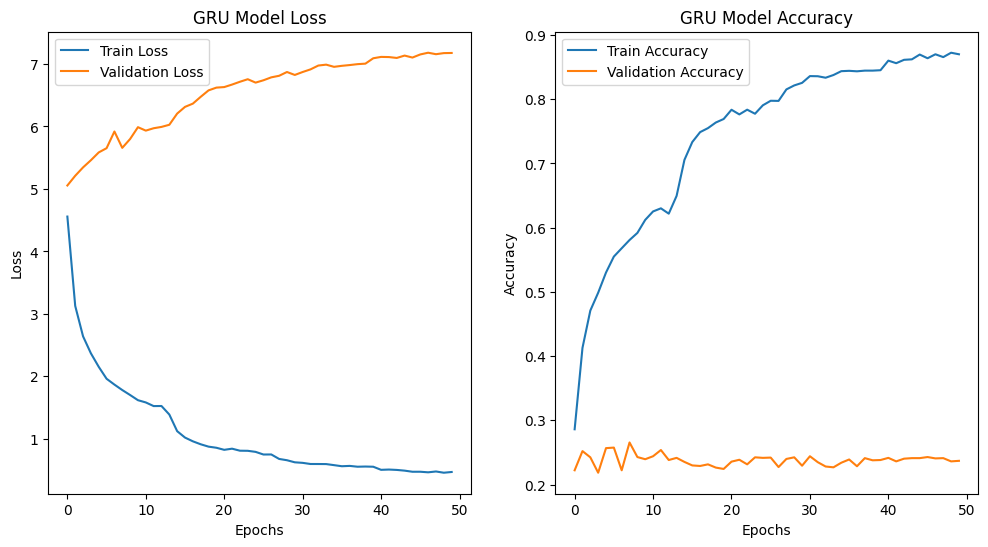

In [210]:
import matplotlib.pyplot as plt

history_gru1 = gru_model1.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
gru_model1.save("gru_model1.h5")

# Plotting training and validation loss for GRU model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru1.history["loss"], label="Train Loss")
plt.plot(history_gru1.history["val_loss"], label="Validation Loss")
plt.title("GRU Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for GRU model
plt.subplot(1, 2, 2)
plt.plot(history_gru1.history["accuracy"], label="Train Accuracy")
plt.plot(history_gru1.history["val_accuracy"], label="Validation Accuracy")
plt.title("GRU Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/50
75/75 [==============================] - 2s 11ms/step - loss: 4.6382 - accuracy: 0.2669 - val_loss: 5.2178 - val_accuracy: 0.2141
Epoch 2/50
75/75 [==============================] - 1s 8ms/step - loss: 3.1626 - accuracy: 0.4091 - val_loss: 5.0973 - val_accuracy: 0.2613
Epoch 3/50
75/75 [==============================] - 0s 6ms/step - loss: 2.5888 - accuracy: 0.4741 - val_loss: 5.1408 - val_accuracy: 0.2608
Epoch 4/50
75/75 [==============================] - 1s 7ms/step - loss: 2.1957 - accuracy: 0.5332 - val_loss: 5.2426 - val_accuracy: 0.2625
Epoch 5/50
75/75 [==============================] - 1s 7ms/step - loss: 1.9086 - accuracy: 0.5739 - val_loss: 5.4175 - val_accuracy: 0.2625
Epoch 6/50
75/75 [==============================] - 0s 6ms/step - loss: 1.6835 - accuracy: 0.6088 - val_loss: 5.4449 - val_accuracy: 0.2570
Epoch 7/50
75/75 [==============================] - 1s 7ms/step - loss: 1.5283 - accuracy: 0.6409 - val_loss: 5.6587 - val_accuracy: 0.2600
Epoch 8/50
75/75 [=

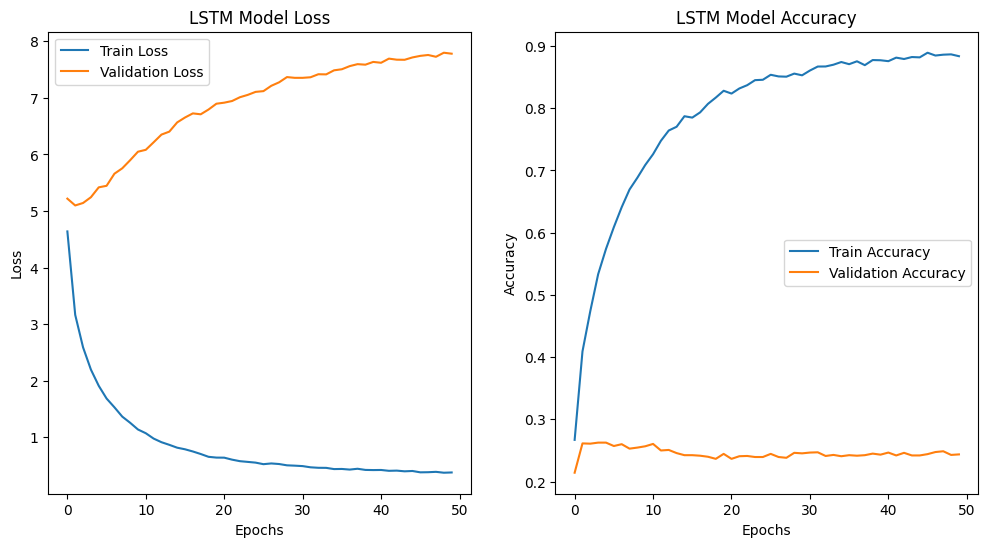

In [211]:
# Train the LSTM model
history_lstm1 = lstm_model1.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
lstm_model1.save("lstm_model1.h5")

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm1.history["loss"], label="Train Loss")
plt.plot(history_lstm1.history["val_loss"], label="Validation Loss")
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_lstm1.history["accuracy"], label="Train Accuracy")
plt.plot(history_lstm1.history["val_accuracy"], label="Validation Accuracy")
plt.title("LSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

====================================

In [212]:
import numpy as np


def generate_text1(start_word, model, max_sequence_len, temperature=1, num_words=10):
    # Convert the start word to a tokenized sequence
    sequence = Tokenizer().texts_to_sequences([start_word])[0]
    sequence = pad_sequences([sequence], maxlen=max_sequence_len, padding="post")

    generated = start_word

    # Generating words
    for _ in range(num_words):
        predictions = model.predict(sequence)[0]

        predictions = np.asarray(predictions).astype("float64")
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        next_word_idx = np.random.choice(len(predictions), p=predictions)

        next_word = tokenizer.index_word[next_word_idx]
        generated += " " + next_word

        sequence = sequence.tolist()[0]
        sequence.append(next_word_idx)
        sequence = sequence[1:]
        sequence = pad_sequences([sequence], maxlen=max_sequence_len, padding="post")

    return generated


# Example usage
generated_text = generate_text1('embrace', lstm_model1, max_sequence_len, temperature=1, num_words=10)
print(generated_text)

1/1 [==============================] - 0s 15ms/step
embrace and miracles every challenge faced is an opportunity for growth


===========================================================================================================================================================================


In [254]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import tensorflow as tf

class Customlr(LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate):
        super(Customlr, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def __call__(self, step):
        return self.initial_learning_rate / (1 + self.decay_rate * tf.math.floor(step / self.decay_steps))
    
    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate
        }
    
data = pd.read_csv("./dataset/train.csv")
text = "\n".join(data["Quotes"]).lower().split('\n')
text = [text.replace(';', ' ;') for text in text]
text = [text.replace('.', ' .') for text in text]
text = [text.replace(',', ' ,') for text in text]
text = [text.replace("it's", 'it is') for text in text]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
vocab_size = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

if input_sequences:
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
else:
    print("Debug: sequences not generated")

# split
X = input_sequences[:,:-1]
y = to_categorical(input_sequences[:,-1], num_classes=vocab_size)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"{X_train.shape}, {X_val.shape}, {y_train.shape}, {y_val.shape}")
print(f"{X_train}, {y_train}")

(8711, 34), (2178, 34), (8711, 1198), (2178, 1198)
[[  0   0   0 ... 407  13 486]
 [  0   0   0 ...  30 676  24]
 [  0   0   0 ...  46   2 119]
 ...
 [  0   0   0 ...   0   0   9]
 [  0   0   0 ...   0   0  19]
 [  0   0   0 ...  16  14  24]], [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [214]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
rate = 0.6
epochs = 50
batch_size = 128
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.96
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [215]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    GRU,
    LSTM,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization
)

# Bidirectional GRU Model
gru_model2 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        GRU(128),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),
    ]
)
gru_model2.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

# Bidirectional LSTM Model
lstm_model2 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        LSTM(128),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),

    ]
)
lstm_model2.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
print(gru_model2.summary())
print(lstm_model2.summary())

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 34, 256)           306688    
                                                                 
 gru_14 (GRU)                (None, 128)               148224    
                                                                 
 dropout_86 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_32 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_78 (Dense)            (None, 1198)              154542    
                                                                 
Total params: 609,966
Trainable params: 609,710
Non-trainable params: 256
_____________________________________________

Epoch 1/50
69/69 [==============================] - 2s 13ms/step - loss: 4.6277 - accuracy: 0.2996 - val_loss: 3.6047 - val_accuracy: 0.3903
Epoch 2/50
69/69 [==============================] - 1s 8ms/step - loss: 3.2552 - accuracy: 0.4230 - val_loss: 3.1182 - val_accuracy: 0.4679
Epoch 3/50
69/69 [==============================] - 1s 8ms/step - loss: 2.7943 - accuracy: 0.4641 - val_loss: 2.9709 - val_accuracy: 0.4725
Epoch 4/50
69/69 [==============================] - 1s 8ms/step - loss: 2.4236 - accuracy: 0.5079 - val_loss: 2.9081 - val_accuracy: 0.4995
Epoch 5/50
69/69 [==============================] - 1s 8ms/step - loss: 2.2643 - accuracy: 0.5273 - val_loss: 2.9215 - val_accuracy: 0.4982
Epoch 6/50
69/69 [==============================] - 1s 8ms/step - loss: 2.2070 - accuracy: 0.5231 - val_loss: 2.8894 - val_accuracy: 0.5115
Epoch 7/50
69/69 [==============================] - 1s 8ms/step - loss: 2.0252 - accuracy: 0.5502 - val_loss: 2.9142 - val_accuracy: 0.5262
Epoch 8/50
69/69 [=

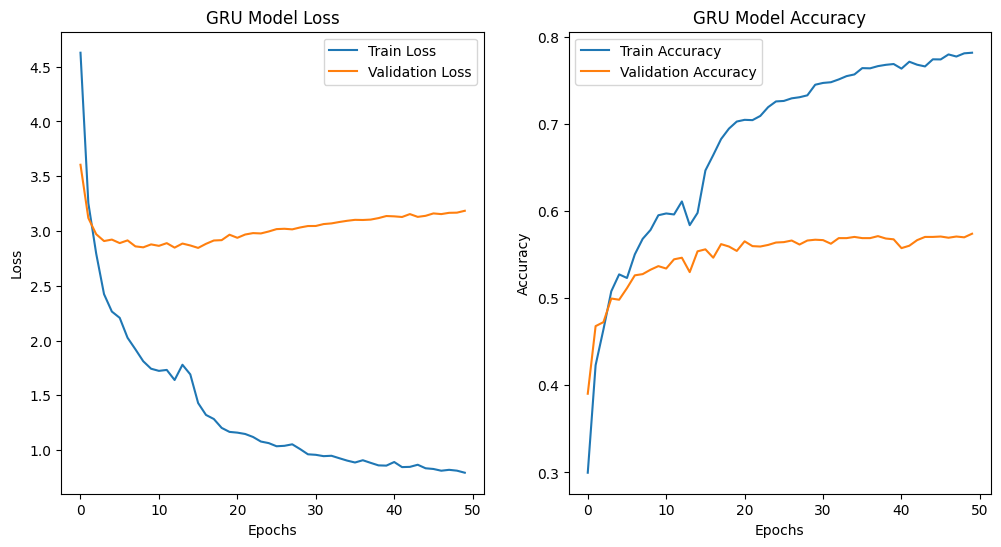

In [216]:
import matplotlib.pyplot as plt

history_gru2 = gru_model2.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
gru_model2.save("gru_model.h5")

# Plotting training and validation loss for GRU model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru2.history["loss"], label="Train Loss")
plt.plot(history_gru2.history["val_loss"], label="Validation Loss")
plt.title("GRU Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for GRU model
plt.subplot(1, 2, 2)
plt.plot(history_gru2.history["accuracy"], label="Train Accuracy")
plt.plot(history_gru2.history["val_accuracy"], label="Validation Accuracy")
plt.title("GRU Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/50
69/69 [==============================] - 2s 13ms/step - loss: 4.8003 - accuracy: 0.2694 - val_loss: 3.9648 - val_accuracy: 0.3820
Epoch 2/50
69/69 [==============================] - 1s 9ms/step - loss: 3.3225 - accuracy: 0.4079 - val_loss: 3.3109 - val_accuracy: 0.4472
Epoch 3/50
69/69 [==============================] - 1s 9ms/step - loss: 2.7377 - accuracy: 0.4762 - val_loss: 2.9804 - val_accuracy: 0.4766
Epoch 4/50
69/69 [==============================] - 1s 9ms/step - loss: 2.3713 - accuracy: 0.5172 - val_loss: 2.8133 - val_accuracy: 0.5092
Epoch 5/50
69/69 [==============================] - 1s 10ms/step - loss: 2.0675 - accuracy: 0.5567 - val_loss: 2.7479 - val_accuracy: 0.5230
Epoch 6/50
69/69 [==============================] - 1s 10ms/step - loss: 1.8372 - accuracy: 0.5867 - val_loss: 2.7458 - val_accuracy: 0.5386
Epoch 7/50
69/69 [==============================] - 1s 10ms/step - loss: 1.6804 - accuracy: 0.6092 - val_loss: 2.7520 - val_accuracy: 0.5459
Epoch 8/50
69/69

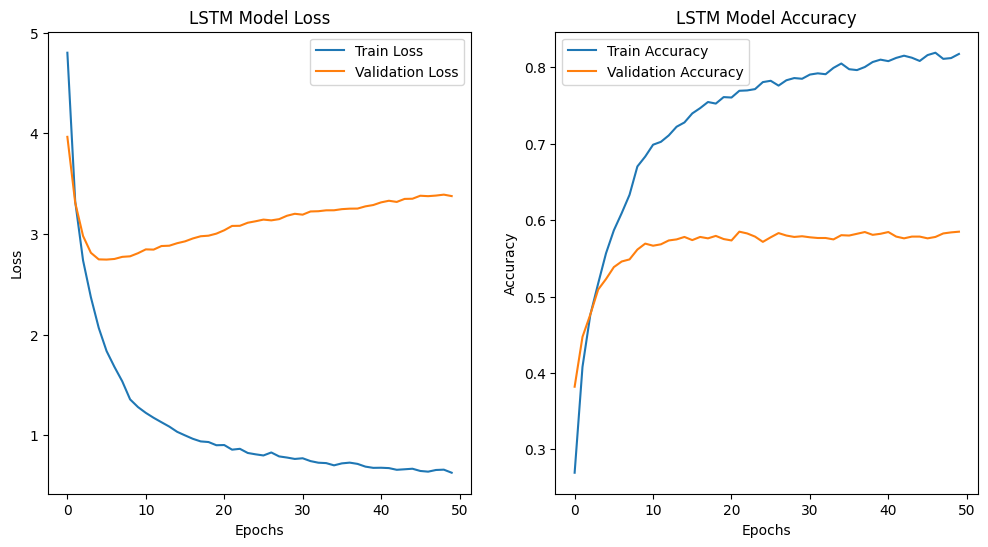

In [217]:
# Train the LSTM model
history_lstm2 = lstm_model2.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
lstm_model2.save("lstm_model.h5")

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm2.history["loss"], label="Train Loss")
plt.plot(history_lstm2.history["val_loss"], label="Validation Loss")
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_lstm2.history["accuracy"], label="Train Accuracy")
plt.plot(history_lstm2.history["val_accuracy"], label="Validation Accuracy")
plt.title("LSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

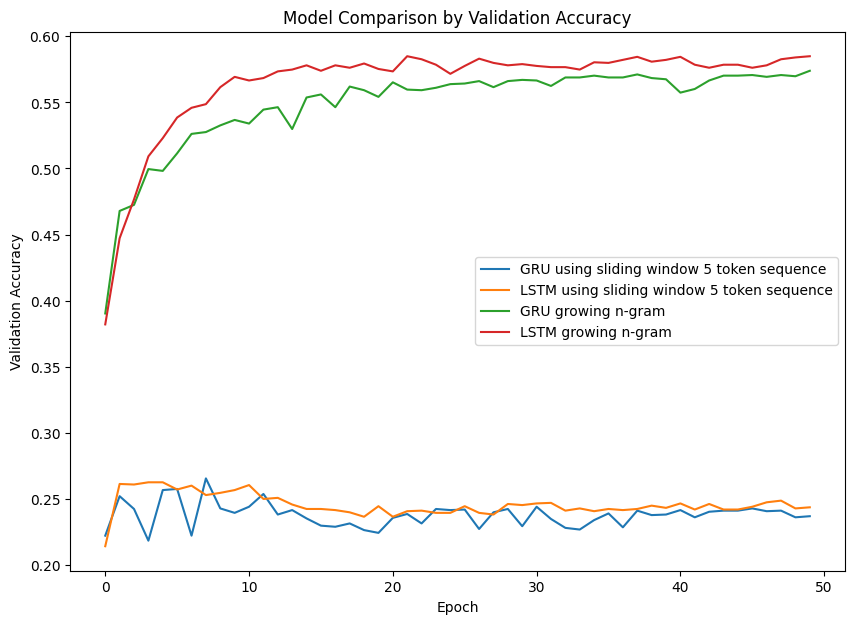

In [218]:
plt.figure(figsize=(10, 7))
# Plotting both models
plt.plot(history_gru1.history["val_accuracy"], label='GRU using sliding window 5 token sequence')
plt.plot(history_lstm1.history["val_accuracy"], label='LSTM using sliding window 5 token sequence')
plt.plot(history_gru2.history["val_accuracy"], label='GRU growing n-gram')
plt.plot(history_lstm2.history["val_accuracy"], label='LSTM growing n-gram')

# Labeling the plot
plt.title('Model Comparison by Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.show()

===========================================================================================================

In [219]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
rate = 0.6
epochs = 100
batch_size = 128
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.96
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [220]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    GRU,
    LSTM,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization
)

# Bidirectional GRU Model
bigru_model1 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        Bidirectional(GRU(128)),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),
    ]
)
bigru_model1.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

# Bidirectional LSTM Model
bilstm_model1 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        Bidirectional(LSTM(128)),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),

    ]
)
bilstm_model1.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
print(bigru_model1.summary())
print(bilstm_model1.summary())

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 34, 256)           306688    
                                                                 
 bidirectional_16 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 dropout_88 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_34 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_80 (Dense)            (None, 1198)              307886    
                                                                 
Total params: 912,046
Trainable params: 911,534
Non-t

Epoch 1/100
69/69 [==============================] - 5s 42ms/step - loss: 4.7407 - accuracy: 0.2835 - val_loss: 3.7344 - val_accuracy: 0.3903
Epoch 2/100
69/69 [==============================] - 1s 13ms/step - loss: 3.3354 - accuracy: 0.4144 - val_loss: 3.0949 - val_accuracy: 0.4550
Epoch 3/100
69/69 [==============================] - 1s 12ms/step - loss: 2.8448 - accuracy: 0.4678 - val_loss: 2.9974 - val_accuracy: 0.4821
Epoch 4/100
69/69 [==============================] - 1s 12ms/step - loss: 2.4717 - accuracy: 0.5042 - val_loss: 2.9438 - val_accuracy: 0.4982
Epoch 5/100
69/69 [==============================] - 1s 12ms/step - loss: 2.2377 - accuracy: 0.5305 - val_loss: 2.9112 - val_accuracy: 0.4881
Epoch 6/100
69/69 [==============================] - 1s 11ms/step - loss: 2.1034 - accuracy: 0.5432 - val_loss: 2.8808 - val_accuracy: 0.5184
Epoch 7/100
69/69 [==============================] - 1s 12ms/step - loss: 1.9768 - accuracy: 0.5658 - val_loss: 2.9057 - val_accuracy: 0.5193
Epoch 

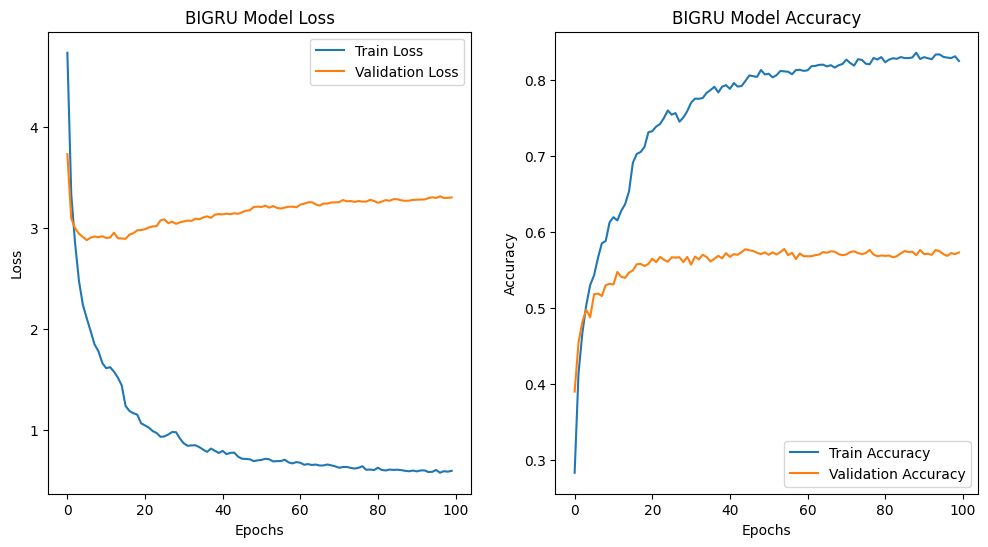

In [221]:
import matplotlib.pyplot as plt

history_bigru1 = bigru_model1.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
bigru_model1.save("bigru_model1.h5")

# Plotting training and validation loss for GRU model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_bigru1.history["loss"], label="Train Loss")
plt.plot(history_bigru1.history["val_loss"], label="Validation Loss")
plt.title("BIGRU Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for GRU model
plt.subplot(1, 2, 2)
plt.plot(history_bigru1.history["accuracy"], label="Train Accuracy")
plt.plot(history_bigru1.history["val_accuracy"], label="Validation Accuracy")
plt.title("BIGRU Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/100
69/69 [==============================] - 4s 23ms/step - loss: 4.9407 - accuracy: 0.2662 - val_loss: 4.8492 - val_accuracy: 0.3508
Epoch 2/100
69/69 [==============================] - 1s 12ms/step - loss: 3.3197 - accuracy: 0.4169 - val_loss: 4.0277 - val_accuracy: 0.4201
Epoch 3/100
69/69 [==============================] - 1s 12ms/step - loss: 2.7452 - accuracy: 0.4804 - val_loss: 3.4274 - val_accuracy: 0.4596
Epoch 4/100
69/69 [==============================] - 1s 12ms/step - loss: 2.3556 - accuracy: 0.5282 - val_loss: 3.0667 - val_accuracy: 0.4954
Epoch 5/100
69/69 [==============================] - 1s 12ms/step - loss: 2.1004 - accuracy: 0.5549 - val_loss: 2.8173 - val_accuracy: 0.5174
Epoch 6/100
69/69 [==============================] - 1s 12ms/step - loss: 1.8926 - accuracy: 0.5895 - val_loss: 2.7523 - val_accuracy: 0.5266
Epoch 7/100
69/69 [==============================] - 1s 12ms/step - loss: 1.7064 - accuracy: 0.6152 - val_loss: 2.7374 - val_accuracy: 0.5363
Epoch 

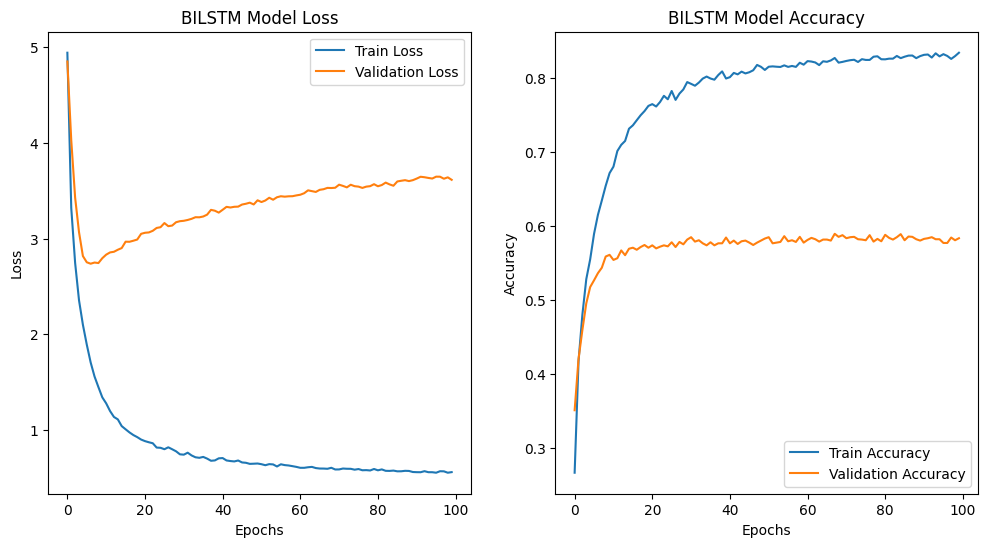

In [222]:
# Train the LSTM model
history_bilstm1 = bilstm_model1.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
bilstm_model1.save("bilstm_model1.h5")

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm1.history["loss"], label="Train Loss")
plt.plot(history_bilstm1.history["val_loss"], label="Validation Loss")
plt.title("BILSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_bilstm1.history["accuracy"], label="Train Accuracy")
plt.plot(history_bilstm1.history["val_accuracy"], label="Validation Accuracy")
plt.title("BILSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

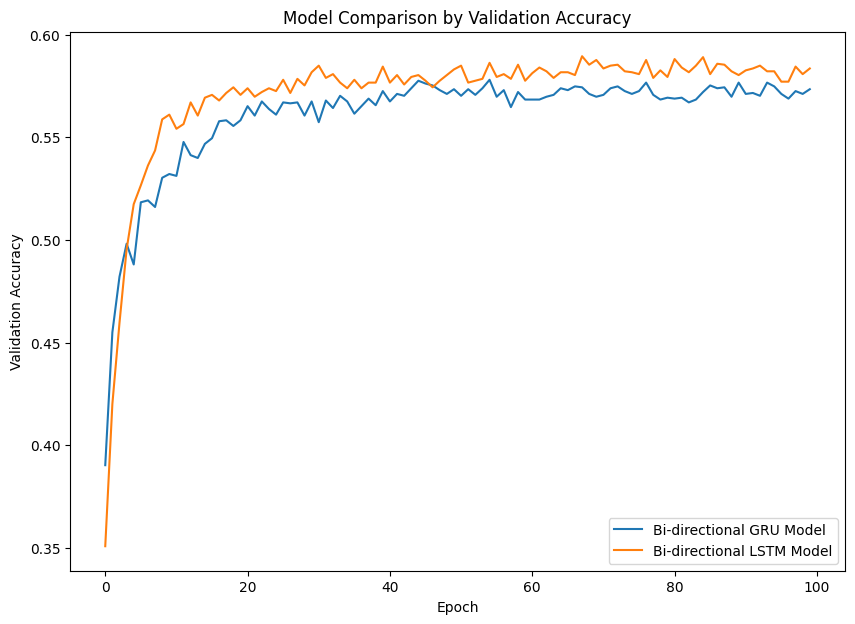

In [223]:
plt.figure(figsize=(10, 7))
# Plotting both models
plt.plot(history_bigru1.history["val_accuracy"], label='Bi-directional GRU Model')
plt.plot(history_bilstm1.history["val_accuracy"], label='Bi-directional LSTM Model')

# Labeling the plot
plt.title('Model Comparison by Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.show()

===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [240]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
rate = 0.6
epochs = 150
batch_size = 64
initial_learning_rate = 0.01
decay_steps = 2000
decay_rate = 0.99
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [247]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    GRU,
    LSTM,
    Dense,
    Dropout,
    BatchNormalization
)

# Bidirectional LSTM Model
bilstm_model2 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        Bidirectional(LSTM(1024)),
        Dropout(rate),
        BatchNormalization(),
        Dropout(rate),
        Dense(vocab_size, activation='softmax', kernel_regularizer=regularizers.l2(0.01)),
    ]
)

bilstm_model2.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

print(bilstm_model2.summary())

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, 34, 256)           306688    
                                                                 
 bidirectional_22 (Bidirecti  (None, 2048)             10493952  
 onal)                                                           
                                                                 
 dropout_107 (Dropout)       (None, 2048)              0         
                                                                 
 batch_normalization_39 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_108 (Dropout)       (None, 2048)              0         
                                                                 
 dense_96 (Dense)            (None, 1198)            

Epoch 1/150
137/137 [==============================] - 8s 41ms/step - loss: 14.1330 - accuracy: 0.0414 - val_loss: 12.5258 - val_accuracy: 0.0721
Epoch 2/150
137/137 [==============================] - 5s 37ms/step - loss: 10.6216 - accuracy: 0.0767 - val_loss: 8.7183 - val_accuracy: 0.1428
Epoch 3/150
137/137 [==============================] - 5s 36ms/step - loss: 8.0993 - accuracy: 0.1119 - val_loss: 7.3467 - val_accuracy: 0.1657
Epoch 4/150
137/137 [==============================] - 5s 36ms/step - loss: 7.1440 - accuracy: 0.1341 - val_loss: 6.5731 - val_accuracy: 0.1827
Epoch 5/150
137/137 [==============================] - 5s 36ms/step - loss: 6.6692 - accuracy: 0.1456 - val_loss: 6.4313 - val_accuracy: 0.2066
Epoch 6/150
137/137 [==============================] - 5s 36ms/step - loss: 6.4275 - accuracy: 0.1552 - val_loss: 6.1344 - val_accuracy: 0.2199
Epoch 7/150
137/137 [==============================] - 5s 36ms/step - loss: 6.2732 - accuracy: 0.1699 - val_loss: 6.1038 - val_accura

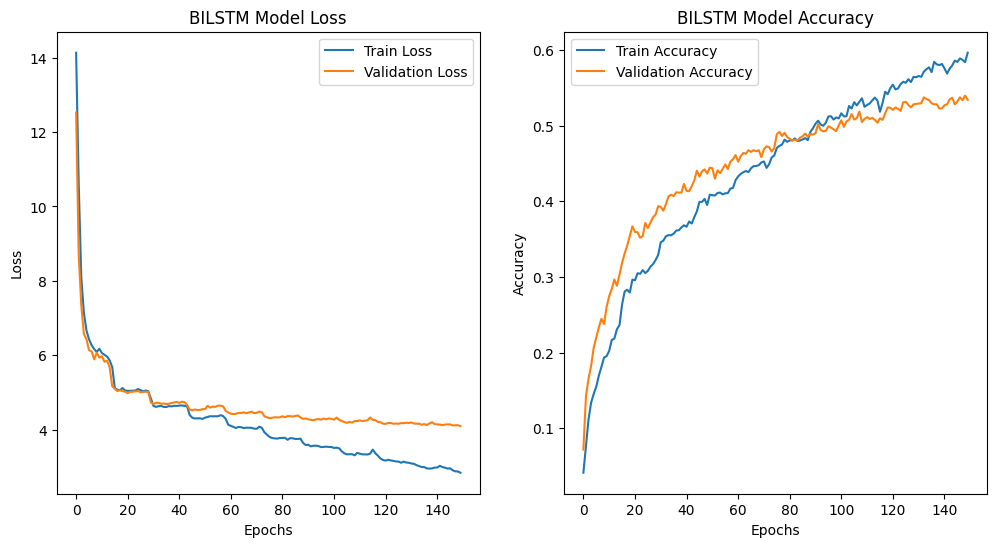

In [248]:
# Train the LSTM model
history_bilstm2 = bilstm_model2.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
bilstm_model2.save("bilstm_model2.h5")

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm2.history["loss"], label="Train Loss")
plt.plot(history_bilstm2.history["val_loss"], label="Validation Loss")
plt.title("BILSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_bilstm2.history["accuracy"], label="Train Accuracy")
plt.plot(history_bilstm2.history["val_accuracy"], label="Validation Accuracy")
plt.title("BILSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

=======================================================================================

In [227]:
embed_dim = 64  # Embedding size for each token
num_heads = 16  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer
rate = 0.6
epochs = 300
batch_size = 64
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.96
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [228]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, MultiHeadAttention, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.6):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Token and Position Embedding
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

inputs = Input(shape=(max_sequence_len - 1,))
embedding_layer = TokenAndPositionEmbedding(max_sequence_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(rate)(x)
outputs = Dense(vocab_size, activation="softmax", kernel_regularizer=regularizers.l2(0.01))(x)

transformer_model1 = Model(inputs=inputs, outputs=outputs)

# Compile the model
transformer_model1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
print(transformer_model1.summary())



Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 34)]              0         
                                                                 
 token_and_position_embeddin  (None, 34, 64)           78912     
 g_13 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_13 (Trans  (None, 34, 64)           273856    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_17  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_94 (Dropout)        (None, 64)                0  

Epoch 1/300
137/137 [==============================] - 4s 16ms/step - loss: 6.0475 - accuracy: 0.0807 - val_loss: 5.9696 - val_accuracy: 0.0904
Epoch 2/300
137/137 [==============================] - 2s 13ms/step - loss: 5.6839 - accuracy: 0.0814 - val_loss: 5.4948 - val_accuracy: 0.1129
Epoch 3/300
137/137 [==============================] - 2s 13ms/step - loss: 5.3928 - accuracy: 0.1021 - val_loss: 5.4007 - val_accuracy: 0.1708
Epoch 4/300
137/137 [==============================] - 2s 13ms/step - loss: 5.1755 - accuracy: 0.1558 - val_loss: 5.3906 - val_accuracy: 0.1951
Epoch 5/300
137/137 [==============================] - 2s 12ms/step - loss: 4.9825 - accuracy: 0.1902 - val_loss: 5.1982 - val_accuracy: 0.2236
Epoch 6/300
137/137 [==============================] - 2s 12ms/step - loss: 4.8865 - accuracy: 0.2125 - val_loss: 5.0318 - val_accuracy: 0.2608
Epoch 7/300
137/137 [==============================] - 2s 12ms/step - loss: 4.7947 - accuracy: 0.2453 - val_loss: 5.0489 - val_accuracy:

INFO:tensorflow:Assets written to: transformer_model1\assets


INFO:tensorflow:Assets written to: transformer_model1\assets


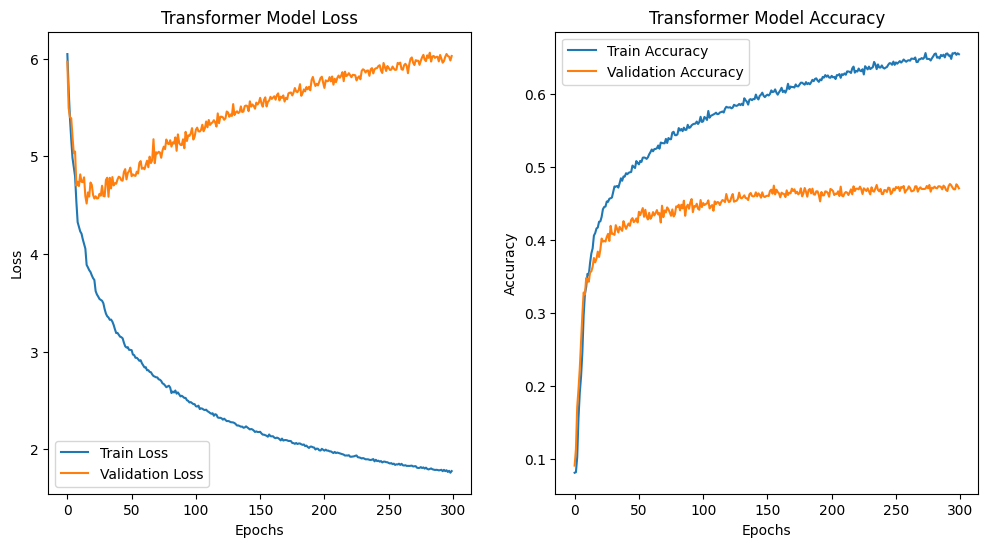

In [229]:
# Train the model
history_transformer1 = transformer_model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
tf.keras.models.save_model(transformer_model1, 'transformer_model1')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_transformer1.history["loss"], label="Train Loss")
plt.plot(history_transformer1.history["val_loss"], label="Validation Loss")
plt.title("Transformer Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_transformer1.history["accuracy"], label="Train Accuracy")
plt.plot(history_transformer1.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

======================================================================

In [230]:
embed_dim = 64  # Embedding size for each token
num_heads = 16  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer
lstm_dim = 64  # LSTM units
rate = 0.6
epochs = 300
batch_size = 64
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.96
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [232]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, MultiHeadAttention, Dropout, LayerNormalization, GlobalAveragePooling1D, Concatenate

# Input layer
inputs = Input(shape=(max_sequence_len - 1,))

# Embedding layer shared by both branches
embedding_layer = TokenAndPositionEmbedding(max_sequence_len, vocab_size, embed_dim)
x = embedding_layer(inputs)

# Transformer branch
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_output = transformer_block(x)
transformer_output = GlobalAveragePooling1D()(transformer_output)

# BiLSTM branch
lstm_output = LSTM(lstm_dim)(x)
lstm_output = Flatten()(lstm_output)

# Concatenate both branches
flatten = Concatenate()([transformer_output, lstm_output])

# Dropout layer
x = Dropout(rate)(flatten)

# Output layer
outputs = Dense(vocab_size, activation="softmax")(x)

# Create and compile model
transformerLSTM_model1 = Model(inputs=inputs, outputs=outputs)
transformerLSTM_model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(transformerLSTM_model1.summary())


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 34, 64)      78912       ['input_16[0][0]']               
 5 (TokenAndPositionEmbedding)                                                                    
                                                                                                  
 transformer_block_15 (Transfor  (None, 34, 64)      273856      ['token_and_position_embedding_15
 merBlock)                                                       [0][0]']                         
                                                                                           

Epoch 1/300
137/137 [==============================] - 4s 17ms/step - loss: 5.2918 - accuracy: 0.1288 - val_loss: 4.6880 - val_accuracy: 0.2185
Epoch 2/300
137/137 [==============================] - 2s 15ms/step - loss: 4.2855 - accuracy: 0.2694 - val_loss: 4.2194 - val_accuracy: 0.3434
Epoch 3/300
137/137 [==============================] - 2s 14ms/step - loss: 3.7941 - accuracy: 0.3356 - val_loss: 3.7413 - val_accuracy: 0.3866
Epoch 4/300
137/137 [==============================] - 2s 14ms/step - loss: 3.4546 - accuracy: 0.3725 - val_loss: 3.6354 - val_accuracy: 0.4054
Epoch 5/300
137/137 [==============================] - 2s 14ms/step - loss: 3.1851 - accuracy: 0.4034 - val_loss: 3.5943 - val_accuracy: 0.4082
Epoch 6/300
137/137 [==============================] - 2s 14ms/step - loss: 2.9978 - accuracy: 0.4211 - val_loss: 3.3007 - val_accuracy: 0.4412
Epoch 7/300
137/137 [==============================] - 2s 13ms/step - loss: 2.8363 - accuracy: 0.4389 - val_loss: 3.3005 - val_accuracy:

INFO:tensorflow:Assets written to: transformerLSTM_model1\assets


INFO:tensorflow:Assets written to: transformerLSTM_model1\assets


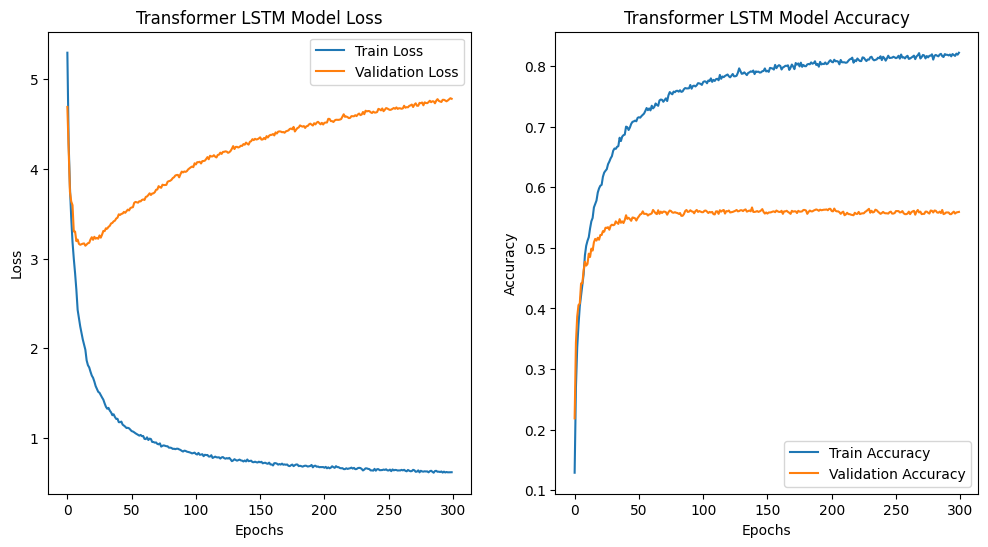

In [233]:
history_transformerLSTM1 = transformerLSTM_model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
tf.keras.models.save_model(transformer_model1, 'transformerLSTM_model1')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_transformerLSTM1.history["loss"], label="Train Loss")
plt.plot(history_transformerLSTM1.history["val_loss"], label="Validation Loss")
plt.title("Transformer LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_transformerLSTM1.history["accuracy"], label="Train Accuracy")
plt.plot(history_transformerLSTM1.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer LSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [234]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, MultiHeadAttention, Dropout, LayerNormalization, GlobalAveragePooling1D, Concatenate

# Input layer
inputs = Input(shape=(max_sequence_len - 1,))

# Embedding layer shared by both branches
embedding_layer = TokenAndPositionEmbedding(max_sequence_len, vocab_size, embed_dim)
x = embedding_layer(inputs)

# Transformer branch
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_output = transformer_block(x)
transformer_output = GlobalAveragePooling1D()(transformer_output)

# BiLSTM branch
bilstm_output = Bidirectional(LSTM(lstm_dim, return_sequences=True))(x)
bilstm_output = GlobalAveragePooling1D()(bilstm_output)

# Concatenate both branches
flatten = Concatenate()([transformer_output, bilstm_output])

# Dropout layer
x = Dropout(rate)(flatten)

# Output layer
outputs = Dense(vocab_size, activation="softmax")(x)

# Create and compile model
transformerBILSTM_model1 = Model(inputs=inputs, outputs=outputs)
transformerBILSTM_model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(transformerBILSTM_model1.summary())



Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 34, 64)      78912       ['input_17[0][0]']               
 6 (TokenAndPositionEmbedding)                                                                    
                                                                                                  
 transformer_block_16 (Transfor  (None, 34, 64)      273856      ['token_and_position_embedding_16
 merBlock)                                                       [0][0]']                         
                                                                                           

Epoch 1/300
137/137 [==============================] - 6s 23ms/step - loss: 5.6580 - accuracy: 0.0847 - val_loss: 5.3426 - val_accuracy: 0.0950
Epoch 2/300
137/137 [==============================] - 2s 18ms/step - loss: 5.2529 - accuracy: 0.0960 - val_loss: 5.4276 - val_accuracy: 0.1006
Epoch 3/300
137/137 [==============================] - 2s 17ms/step - loss: 5.1273 - accuracy: 0.0985 - val_loss: 5.4624 - val_accuracy: 0.0978
Epoch 4/300
137/137 [==============================] - 3s 20ms/step - loss: 5.0723 - accuracy: 0.0986 - val_loss: 5.5087 - val_accuracy: 0.1010
Epoch 5/300
137/137 [==============================] - 3s 20ms/step - loss: 5.0274 - accuracy: 0.0978 - val_loss: 5.6074 - val_accuracy: 0.1015
Epoch 6/300
137/137 [==============================] - 3s 19ms/step - loss: 4.9913 - accuracy: 0.0962 - val_loss: 5.5625 - val_accuracy: 0.0909
Epoch 7/300
137/137 [==============================] - 3s 19ms/step - loss: 4.9617 - accuracy: 0.0938 - val_loss: 5.6286 - val_accuracy:

INFO:tensorflow:Assets written to: transformerBILSTM_model1\assets


INFO:tensorflow:Assets written to: transformerBILSTM_model1\assets


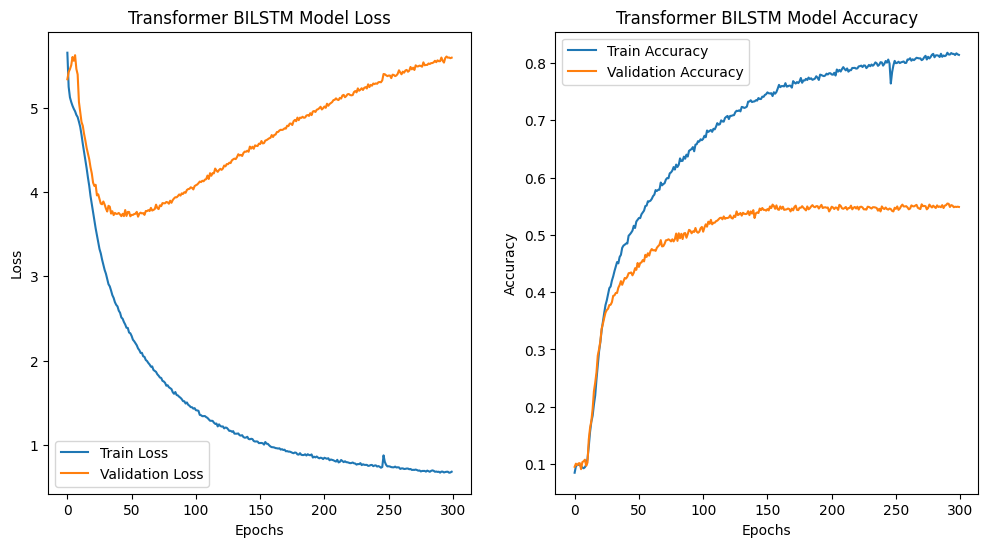

In [235]:
history_transformerBILSTM1 = transformerBILSTM_model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
tf.keras.models.save_model(transformer_model1, 'transformerBILSTM_model1')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_transformerBILSTM1.history["loss"], label="Train Loss")
plt.plot(history_transformerBILSTM1.history["val_loss"], label="Validation Loss")
plt.title("Transformer BILSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_transformerBILSTM1.history["accuracy"], label="Train Accuracy")
plt.plot(history_transformerBILSTM1.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer BILSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

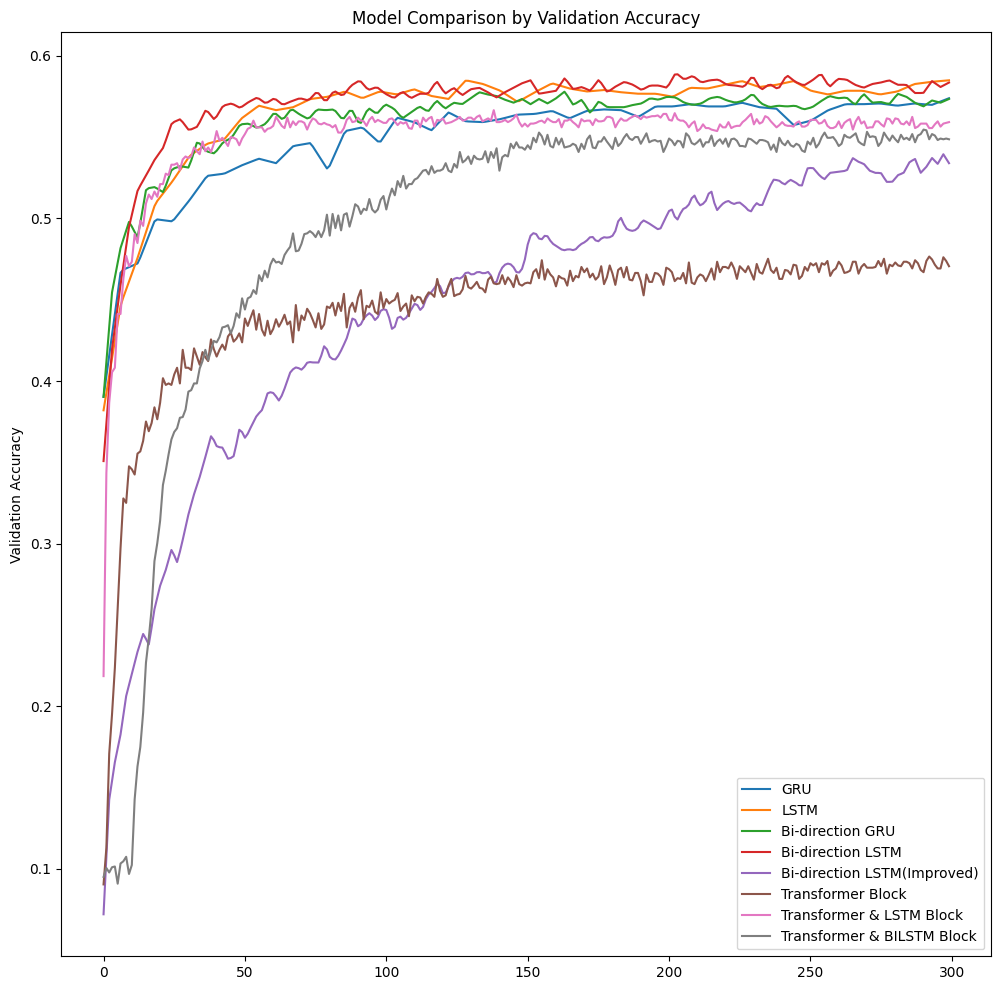

In [251]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


gru2 = len(history_gru2.history["val_accuracy"])
lstm2 = len(history_lstm2.history["val_accuracy"])
bigru1 = len(history_bigru1.history["val_accuracy"])
bilstm1 = len(history_bilstm1.history["val_accuracy"])
bilstm2 = len(history_bilstm2.history["val_accuracy"])
transformer1 = len(history_transformer1.history["val_accuracy"])
transformerLSTM1 = len(history_transformerLSTM1.history["val_accuracy"])
transformerBILSTM1 = len(history_transformerBILSTM1.history["val_accuracy"])

max_epochs = max(gru2, lstm2, bigru1, bilstm1, bilstm2, transformer1, transformerLSTM1, transformerBILSTM1)

def interpolate_history(history, new_length):
    old_length = len(history.history['val_accuracy'])
    old_epochs = np.arange(old_length)
    new_epochs = np.linspace(0, old_length - 1, new_length)
    interpolated = interpolate.interp1d(old_epochs, history.history['val_accuracy'], kind='linear')
    return interpolated(new_epochs)

acc_gru2 = interpolate_history(history_gru2, max_epochs)
acc_lstm2 = interpolate_history(history_lstm2, max_epochs)
acc_bigru1 = interpolate_history(history_bigru1, max_epochs)
acc_bilstm1 = interpolate_history(history_bilstm1, max_epochs)
acc_bilstm2 = interpolate_history(history_bilstm2, max_epochs)
acc_transformer1 = interpolate_history(history_transformer1, max_epochs)
acc_transformerLSTM1 = interpolate_history(history_transformerLSTM1, max_epochs)
acc_transformerBILSTM1 = interpolate_history(history_transformerBILSTM1, max_epochs)

plt.figure(figsize=(12, 12))
# Plotting both models
plt.plot(acc_gru2, label='GRU')
plt.plot(acc_lstm2, label='LSTM')
plt.plot(acc_bigru1, label='Bi-direction GRU')
plt.plot(acc_bilstm1, label='Bi-direction LSTM')
plt.plot(acc_bilstm2, label='Bi-direction LSTM(Improved)')
plt.plot(acc_transformer1, label='Transformer Block')
plt.plot(acc_transformerLSTM1, label='Transformer & LSTM Block')
plt.plot(acc_transformerBILSTM1, label='Transformer & BILSTM Block')

plt.title('Model Comparison by Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.legend()

# Show the plot
plt.show()

=======================================================================================

In [275]:
def generate_text(start_word, model, temperature, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([start_word])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predictions = np.log(predicted_probs) / temperature
        exp_predictions = np.exp(predictions)
        predicted_probs = exp_predictions / np.sum(exp_predictions)
        chosen_word_index = np.random.choice(range(len(predicted_probs)), p=predicted_probs)
        word = tokenizer.index_word[chosen_word_index]
        start_word += " " + word
        gen_text = start_word.replace(' ;', ';').replace(' .', '.').replace(' ,', ',').replace("it is", "it's")
    return gen_text

In [255]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim.models import LsiModel
from gensim.corpora import Dictionary
import pandas as pd
import numpy as np

# Load and preprocess data
data = pd.read_csv("./dataset/train.csv")
text = "\n".join(data["Quotes"]).lower().split('\n')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

# Function to tokenize a sentence using the fitted tokenizer
def tokenize_sentence(sentence):
    return tokenizer.texts_to_sequences([sentence])[0]

def score_bleu(sentences, verbose=0):
    total_bleu_score = 0
    smoother = SmoothingFunction().method1  # Applying smoothing function
    for sentence in sentences:
        tokenized_ref = [tokenize_sentence(x) for x in text]  # Assuming 'text' is defined elsewhere
        tokenized_sentence = tokenize_sentence(sentence)
        temp = sentence_bleu(tokenized_ref, tokenized_sentence, smoothing_function=smoother, auto_reweigh=True)
        total_bleu_score += temp
        if verbose > 0:
            print(f"{sentence}, {temp}")
    return total_bleu_score / len(sentences)

def score_perplexity(sentences):
    n = 3  # N-gram size
    text = [word_tokenize(sentence.lower()) for sentence in sentences]
    train_data, padded_sents = padded_everygram_pipeline(n, text)
    model = MLE(n)  # Using a Maximum Likelihood Estimator
    model.fit(train_data, padded_sents)
    perplexity = 0
    for sentence in sentences:
        perplexity += model.perplexity(list(ngrams(word_tokenize(sentence.lower()), n)))
    return perplexity / len(sentences)

def score_lsa(sentences):
    text_tokenized = [word_tokenize(sentence.lower()) for sentence in sentences]
    dictionary = Dictionary(text_tokenized)
    corpus = [dictionary.doc2bow(text) for text in text_tokenized]
    lsi = LsiModel(corpus, id2word=dictionary, num_topics=2)
    lsa_scores = [lsi[doc] for doc in corpus]
    return lsa_scores


In [276]:
seed_texts = ['embrace each day',
 'radiate some',
 'believe that',
 "life's actual purpose is",
 'dance through each and every',
 'let your time and energy',
 'every person is',
 'our country Singapore is',
 'planet earth is',
 'morning and evening would make it']

In [277]:
models = {
    'gru_model2': gru_model2,
    'lstm_model2': lstm_model2,
    'bigru_model1': bigru_model1,
    'bilstm_model1': bilstm_model1,
    'bilstm_model2': bilstm_model2,
    'transformer_model1': transformer_model1,
    'transformerLSTM_model1': transformerLSTM_model1,
    'transformerBILSTM_model1': transformerBILSTM_model1
}

for model_name, model in models.items():
    sentences = []
    for seed in seed_texts:
        generated_sentence = generate_text(seed, model, temperature=0.1, num_words=10)
        sentences.append(generated_sentence)

    print(f"\n{model_name}")
    print("\tAverage BLEU Score:", score_bleu(sentences))
    print("\tAverage Perplexity:", score_perplexity(sentences))
    print("\tLSA Scores:", score_lsa(sentences))


gru_model2
	Average BLEU Score: 0.5699661799755517
	Average Perplexity: 1.1718679085117596
	LSA Scores: [[(0, 2.5325901327447635), (1, -0.7173186561330411)], [(0, 2.038560118480552), (1, 0.2772694010300567)], [(0, 1.8039329555500567), (1, 1.0513146890073364)], [(0, 2.6457516045196656), (1, -0.21688423324869716)], [(0, 2.353592421320944), (1, 0.19687454748775884)], [(0, 2.037817440613395), (1, 0.43034748093651354)], [(0, 3.2192550257335624), (1, -1.0536412971223528)], [(0, 2.161922682266881), (1, -1.6076081832211424)], [(0, 2.48171524614969), (1, -1.242752149121909)], [(0, 2.587432984334869), (1, 3.3005894260279636)]]

lstm_model2
	Average BLEU Score: 0.7098414285637673
	Average Perplexity: 1.0916019275049171
	LSA Scores: [[(0, 2.9924801324919885), (1, -0.49063237094752715)], [(0, 1.3332390665959564), (1, -0.6841404627375504)], [(0, 1.7263931416065565), (1, -0.23454292721842981)], [(0, 2.1856157250527177), (1, 1.216240476632001)], [(0, 2.905213101784721), (1, -2.5672465517994083)], [(0

In [278]:
from tensorflow.keras.models import load_model

gru_model2 = load_model('gru_model.h5', custom_objects={'Customlr': Customlr})
lstm_model2 = load_model('lstm_model.h5', custom_objects={'Customlr': Customlr})
bigru_model1 = load_model('bigru_model1.h5', custom_objects={'Customlr': Customlr})
bilstm_model1 = load_model('bilstm_model1.h5', custom_objects={'Customlr': Customlr})
bilstm_model2 = load_model('bilstm_model2.h5', custom_objects={'Customlr': Customlr})
transformer_model1 = tf.keras.models.load_model(
    'transformer_model1',
    custom_objects={
        'TransformerBlock': TransformerBlock, 
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'Customlr': Customlr
    }
)
transformerLSTM_model1 = tf.keras.models.load_model(
    'transformer_model1',
    custom_objects={
        'TransformerBlock': TransformerBlock, 
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'Customlr': Customlr
    }
)
transformerBILSTM_model1 = tf.keras.models.load_model(
    'transformer_model1',
    custom_objects={
        'TransformerBlock': TransformerBlock, 
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'Customlr': Customlr
    }
)

In [279]:
seed_texts = ['embrace each day',
 'radiate some',
 'believe that',
 "life's actual purpose is",
 'dance through each and every',
 'let your time and energy',
 'every person is',
 'our country Singapore is',
 'planet earth is',
 'morning and evening would make it']

Closest to Dataset

In [280]:
for seed in seed_texts:
    generated_sentence = generate_text(seed, lstm_model2, temperature=0.1, num_words=15)
    print(generated_sentence)

embrace each day is a fresh start for new beginnings fully of and fresh start and new beginnings
radiate some enthusiasm and let it be the spark that ignites change for your journey is a
believe that yourself and you will be a force of nature is a gift to the soul
life's actual purpose is the music that unique in our hearts and relationships of the world transform around you
dance through each and every day is a gift a gift from the universe a reminder of the marvel the
let your time and energy it can heal warm that resonates in the hearts of others to believe barrier creating
every person is a reminder of the marvel of desires for the boundless possibilities it brings life to
our country Singapore is a reminder of the hope and potential within our planet holds the promise of new
planet earth is a reminder of the hope and potential within our planet holds the promise of new
morning and evening would make it with the gentle embrace of this morning we grasslands the cradle of our planet 

Best Val Accuracy

In [281]:
for seed in seed_texts:
    generated_sentence = generate_text(seed, bilstm_model1, temperature=0.1, num_words=15)
    print(generated_sentence)

embrace each day with a heart cherish of gratitude for it's the music that today the fills
radiate some positivity for it's the energy that propels you forward is a values on the
believe that yourself and you will be a beacon of hope and let it be the guiding
life's actual purpose is the driving force behind a weave life and life well lived life giving oases wetland
dance through each and every act of gratitude is a step towards a joyful heart the heart of the way
let your time and energy be the force that heals and interactions inspire others to believe barrier and path is
every person is a joyful heart be the against on the world around you are worthy of every
our country Singapore is open arms embrace the opportunities that this morning land to you to inspire others to
planet earth is a reminder of the hope and potential within our planet butterflies a precious door in
morning and evening would make it's a gift to the soul of our planet a precious door in the conductor


Attension Transformer(Could focus more on keywords)

In [282]:
for seed in seed_texts:
    generated_sentence = generate_text(seed, transformerBILSTM_model1, temperature=0.1, num_words=15)
    print(generated_sentence)

embrace each day has the power to the world of drives and others let life with purpose and
radiate some gratitude for it turns what you are a step towards the world on the promise
believe that brightens the world will this morning offers the path to your dreams will brightens the
life's actual purpose is the pursuit of our planet's promise of the spirit of your dreams and aspirations and
dance through each and every step taken in faith is a sunrise an singapore's nature is a step towards progress
let your time and energy with the world around you you be your legacy be you is your your your
every person is the pursuit of our planet's promise of the spirit of your dreams and life with
our country Singapore is our planet's witnessing are a reminder of the future of our planet a fresh start
planet earth is the sowing the us to our planet a hearts in the of the breath with
morning and evening would make it's a reminder of the future of our planet our planet a fresh opportunities of
